# Link properties

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random
import timeit
from scipy.spatial import distance as dst
import itertools
import pickle
import scipy.stats as stats

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
import seaborn as sns
#sns.set_theme(style="whitegrid")
#from scipy.stats.stats import spearmanr
#from scipy.stats.stats import pearsonr
from scipy.stats import skew   
import networkx as nx
name_list = ['human_neuron','rat_neuron',
            'monkey_neuron','zebrafish_neuron',
    'vascular_2','vascular_3','vascular_1','mitochondrial','root_1','root_2','anthill','fruit_fly_2','fruit_fly_3','fruit_fly_4','fruit_fly_1']
color_dict = {'root_1':'green','root_2':'olive','mitochondrial':'y','vascular_1':'red','vascular_2':'crimson','vascular_3':'salmon',
              'fruit_fly_2':'purple','fruit_fly_3':'pink','tree':'brown','rat_neuron':'magenta','human_neuron':'indigo',
              'anthill':'silver','fruit_fly_1':'deeppink','fruit_fly_4':'plum','zebrafish_neuron':'blue','monkey_neuron':'teal'}

category_color_dict = {'root_1':'green','root_2':'green','mitochondrial':'blue','vascular_1':'b','vascular_2':'blue','vascular_3':'blue',
              'fruit_fly_2':'red','fruit_fly_3':'red','tree':'green','rat_neuron':'green','human_neuron':'green',
              'anthill':'green','fruit_fly_1':'red','fruit_fly_4':'red','zebrafish_neuron':'green','monkey_neuron':'green'}
name_change_dict = {'mitochondrial':'mitochon','human_neuron':'h_neuron','monkey_neuron':'m_neuron','rat_neuron':'r_neuron','zebrafish_neuron':'z_neuron'}
ordered_name_list = ['root_1','root_2','human_neuron','zebrafish_neuron','monkey_neuron',
                'rat_neuron','anthill','vascular_1','vascular_2','vascular_3',
                'mitochondrial','fruit_fly_1','fruit_fly_2','fruit_fly_3','fruit_fly_4']

In [7]:
network_measures_dict_all = {}
path_source = '1. network_measures_results/'
path_source_1 = '../2. basic_measures/0. link_properties/'
path_source_2 = '../1. data/3. final_data/'
for name in name_list[:]:
    infile = open(path_source+ name + "_network_measures_dict.pkl",'rb')
    network_measures_dict =  pickle.load(infile)
    infile = open(path_source_1 + name + "_basic_results.pkl",'rb')
    link_segment_properties_dict =  pickle.load(infile)
    link_paths = pd.read_csv(path_source_2 +name + '.paths.csv',index_col=[0])
    path_bodyid_list = link_paths[['path_id','source','target']].drop_duplicates().values.tolist()
    G = nx.MultiGraph()
    path_bodyid_dict = {}  
    bodyid_path_dict = {}
    for path_bodyid in path_bodyid_list:
        path_bodyid_dict[path_bodyid[0]] =  (path_bodyid[1],path_bodyid[2])
        bodyid_path_dict[(path_bodyid[1],path_bodyid[2])] = path_bodyid[0]
        bodyid_path_dict[(path_bodyid[2],path_bodyid[1])] = path_bodyid[0] 
    edge_list = []
    for path_id,bodyid_edge in path_bodyid_dict.items():
        edge_list.append([bodyid_edge[0],bodyid_edge[1]])
        G.add_edge(bodyid_edge[0],bodyid_edge[1])
    network_measures_dict['number_of_links'] = len(G.edges())
    network_measures_dict['number_of_nodes'] = len(G.nodes())
    network_measures_dict['link_degree_median'] = np.median(list(network_measures_dict['link_degree_dict'].values()))
    network_measures_dict['link_degree_iqr'] = compute_iqr(list(network_measures_dict['link_degree_dict'].values()))
    network_measures_dict['link_degree'] = str(np.round( network_measures_dict['link_degree_median'] ,2)) + ' \u00B1 ' + str(np.round( network_measures_dict['link_degree_iqr'] ,2)) 
    network_measures_dict['link_betweenness_median'] = np.median(list(network_measures_dict['betw_dict'].values()))
    network_measures_dict['link_betweenness_iqr'] = compute_iqr(list(network_measures_dict['betw_dict'].values()))
    network_measures_dict['link_betweenness'] = str(np.round( network_measures_dict['link_betweenness_median'] ,5)) + ' \u00B1 ' + str(np.round( network_measures_dict['link_betweenness_iqr'] ,5))                                    
    network_measures_dict['link_cs'] = str(np.round(np.median(list(link_segment_properties_dict['c_straightness'].values())),5)) + ' \u00B1 ' + str(np.round(compute_iqr(list(link_segment_properties_dict['c_straightness'].values())),4))
    network_measures_dict['link_segments'] = str(np.round(np.median(list(link_segment_properties_dict['link_segments'].values())),1)) + ' \u00B1 ' + str(np.round(compute_iqr(list(link_segment_properties_dict['link_segments'].values())),1))
    network_measures_dict['link_aspect_ratio'] = str(np.round(np.median(list(link_segment_properties_dict['link_aspect_ratio'].values())),3)) + ' \u00B1 ' + str(np.round(compute_iqr(list(link_segment_properties_dict['link_aspect_ratio'].values())),3))
    network_measures_dict['link_volume_normed'] = str(np.round(np.median(list(link_segment_properties_dict['link_volume_normed'].values())),6)) + ' \u00B1 ' + str(np.round(compute_iqr(list(link_segment_properties_dict['link_volume_normed'].values())),6))
    if name in name_change_dict:
        name = name_change_dict[name]
    network_measures_dict_all[name] = network_measures_dict.copy()

In [11]:
network_measures_dict_all.keys()

dict_keys(['h_neuron', 'r_neuron', 'm_neuron', 'z_neuron', 'vascular_2', 'vascular_3', 'vascular_1', 'mitochon', 'root_1', 'root_2', 'anthill', 'fruit_fly_2', 'fruit_fly_3', 'fruit_fly_4', 'fruit_fly_1'])

In [12]:
measures = ['link_cs','link_segments','link_aspect_ratio','link_volume_normed','network_diameter','link_degree','link_betweenness']
df_measures = {}
for name in ordered_name_list :
    df_measures[name] = {}
    for measure in measures:
        if name in name_change_dict:
            new_name = name_change_dict[name]
        else:
            new_name = name
        df_measures[name][measure] = network_measures_dict_all[new_name ][measure]
df = pd.DataFrame(df_measures).transpose()
df

,link_cs,link_segments,link_aspect_ratio,link_volume_normed,network_diameter,link_degree,link_betweenness
root_1,0.03326 ± 0.1018,4.0 ± 5.0,0.046 ± 0.081,0.000269 ± 0.000664,92,5.0 ± 2.0,0.00203 ± 0.01611
root_2,0.02326 ± 0.0967,4.0 ± 5.0,0.054 ± 0.103,0.000454 ± 0.001339,34,5.0 ± 2.0,0.00487 ± 0.0287
human_neuron,0.06744 ± 0.1298,40.0 ± 66.0,0.002 ± 0.003,0.000332 ± 0.000511,49,4.0 ± 2.0,0.00316 ± 0.01878
zebrafish_neuron,0.07432 ± 0.1877,5.0 ± 8.0,0.053 ± 0.107,0.000513 ± 0.0013,46,4.0 ± 2.0,0.00649 ± 0.06261
monkey_neuron,0.0892 ± 0.0812,62.0 ± 163.0,0.008 ± 0.04,0.002417 ± 0.002779,20,4.0 ± 2.0,0.0129 ± 0.04994
rat_neuron,0.19821 ± 0.1654,18.0 ± 37.0,0.011 ± 0.069,0.0031 ± 0.004209,21,4.0 ± 2.0,0.01075 ± 0.04185
anthill,0.0 ± 0.188,1.0 ± 1.0,0.379 ± 0.367,4.5e-05 ± 5.8e-05,324,5.0 ± 2.0,0.00013 ± 0.00103
vascular_1,0.06068 ± 0.1038,6.0 ± 7.0,0.109 ± 0.17,0.000203 ± 0.000247,27,6.0 ± 0.0,0.00378 ± 0.00434
vascular_2,0.03443 ± 0.1063,9.0 ± 12.0,0.1 ± 0.166,0.000402 ± 0.000555,22,6.0 ± 0.0,0.00643 ± 0.00706
vascular_3,0.10353 ± 0.1978,7.0 ± 10.0,0.083 ± 0.151,0.000418 ± 0.000597,22,6.0 ± 0.0,0.00704 ± 0.00727


# Degree distribution

In [14]:
degree_dict = {}
for name in name_list:    
    path_source_2 = '../1. data/3. final_data/'
    link_paths = pd.read_csv(path_source_2 +name + '.paths.csv',index_col=[0])
    path_bodyid_list = link_paths[['path_id','source','target']].drop_duplicates().values.tolist()
    G = nx.MultiGraph()
    path_bodyid_dict = {}  
    bodyid_path_dict = {}
    for path_bodyid in path_bodyid_list:
        path_bodyid_dict[path_bodyid[0]] =  (path_bodyid[1],path_bodyid[2])
        bodyid_path_dict[(path_bodyid[1],path_bodyid[2])] = path_bodyid[0]
        bodyid_path_dict[(path_bodyid[2],path_bodyid[1])] = path_bodyid[0] 
    edge_list = []
    for path_id,bodyid_edge in path_bodyid_dict.items():
        edge_list.append([bodyid_edge[0],bodyid_edge[1]])
        G.add_edge(bodyid_edge[0],bodyid_edge[1])
    degree_dict[name] =dict(G.degree)
    for key, value in degree_dict[name].items():
        if value == 2:
            print('There is a degree two node',key)

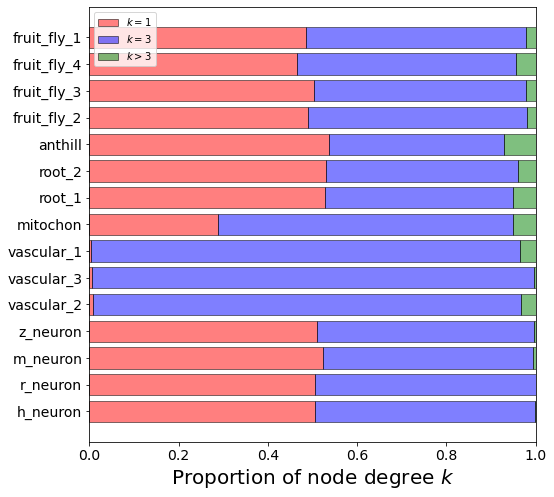

In [15]:

x = []
y = []
y1 = []
y2 = []
y_1_2_sum = []
y3 = []
for name in degree_dict.keys():
    all_values = list(degree_dict[name].values())
    all_keys = list(set(degree_dict[name].values()))
    value_counts_dict = {}
    for key in [1,3]:
         value_counts_dict[key] = all_values.count(key)/len(all_values)
    ratio_1 =  np.round(value_counts_dict[1],3)
    ratio_3 = np.round(value_counts_dict[3],3)
    if name in name_change_dict.keys():
        x.append(name_change_dict[name])
    else:
        x.append(name)
    y1.append(ratio_1)
    y2.append(ratio_3)
    y_1_2_sum.append(ratio_1 + ratio_3)
    y3.append(1-ratio_1 - ratio_3)
    
plt.figure(figsize=(8,8))
plt.barh(x, y1, color='red',orientation='horizontal',label='$k = 1$',alpha=0.5,edgecolor='black')
plt.barh(x, y2, left=y1, color='blue',orientation='horizontal',label='$k = 3$',alpha=0.5,edgecolor='black')
plt.barh(x,y3, left=y_1_2_sum , color='green',orientation='horizontal',label='$k > 3$',alpha=0.5,edgecolor='black')
#plt.bar( value_counts_dict.keys(), value_counts_dict.values(),label='Ratio of 1-3 and 3-3 connections: ' +str(ratio),edgecolor='black',alpha=0.7)
#plt.title('Proportion of node degrees in the network')
#plt.yscale('log')
plt.xlabel("Proportion of node degree $k$")
plt.legend(loc="upper left")
plt.xlim(0,1)
#plt.legend()
plt.savefig('abstract_network_proportion.pdf', format='pdf',dpi=1200)

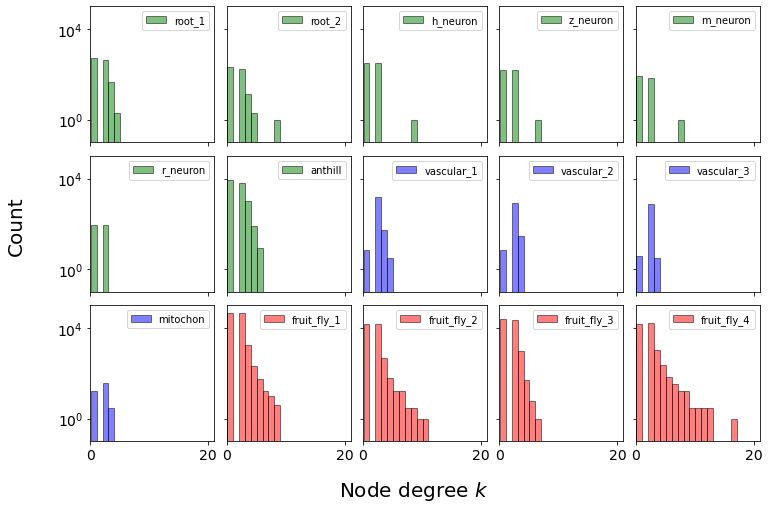

In [16]:
fig, axs = plt.subplots(3, 5, figsize=(12, 8),gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
category_color_dict = {'root_1':'green','root_2':'green','mitochondrial':'blue','vascular_1':'b','vascular_2':'blue','vascular_3':'blue',
              'fruit_fly_2':'red','fruit_fly_3':'red','tree':'green','rat_neuron':'green','human_neuron':'green',
              'anthill':'green','fruit_fly_1':'red','fruit_fly_4':'red','zebrafish_neuron':'green','monkey_neuron':'green'}
ij_name_dict = {'root_1':(0,0),'root_2':(0,1),'anthill':(1,1),'zebrafish_neuron':(0,3) ,'monkey_neuron':(0,4)
                ,'rat_neuron':(1,0), 'human_neuron':(0,2),'vascular_1':(1,2),'vascular_2':(1,3),'vascular_3':(1,4)
                ,'mitochondrial':(2,0),'fruit_fly_1':(2,1),'fruit_fly_2':(2,2),'fruit_fly_3':(2,3),'fruit_fly_4':(2,4)}
for name in name_list:
    if name in name_change_dict.keys():
        label_name = name_change_dict[name]
    else:
        label_name = name
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].hist( list(degree_dict[name].values()),color = category_color_dict[name],label=label_name,alpha=0.5,bins = np.arange(0.1,20.1,1),edgecolor='black')
    labels = axs[ij_name_dict[name][0]][ij_name_dict[name][1]].get_xticklabels()
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].set_yscale('log')
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].set_yticks([1,10000]) 
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].set_xlim(0,21)
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].set_ylim(0.1,100000)
    axs[ij_name_dict[name][0]][ij_name_dict[name][1]].legend()
for ax in axs.flat:
    ax.label_outer()
fig.text(0.5, 0.04, 'Node degree $k$', ha='center', va='center',fontsize=20)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical',fontsize=20)
plt.savefig('degree_dist.pdf', format='pdf',dpi=1200)